In [10]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import pickle as pkl
import os
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set(style='whitegrid')
device = torch.device("cuda")

In [11]:
train_losses_fixlr_2=pkl.load(open("assets_script1/train_losses_fixlr_2.pkl", "rb"))
train_losses_infty = pkl.load(open("assets_script1/train_losses_infty.pkl", "rb"))
train_losses_mup = pkl.load(open("assets_script1/train_losses_mup.pkl", "rb"))
train_losses_ntk = pkl.load(open("assets_script1/train_losses_ntk.pkl", "rb"))
train_losses_ntk_bigbatch = pkl.load(open("assets_script1/train_losses_ntk_bigbatch.pkl", "rb"))

In [182]:
def sample_batch_teacher(B, d_in, device="cuda"):
        W1, W2, W3 = teacher_weights
        x = torch.randn(B, d_in, device=device) / math.sqrt(d_in)
        h = torch.tanh(x @ W1) * 1.5927
        h = torch.tanh(h @ W2) * 1.5927
        y = h @ W3
        return x, y

def train_mup(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda", verbose=False):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        if verbose:
            print(f"Training width {width}")
        for lr in lrs:
            model = MLP2Hidden(d_in, width, 1).to(device)
            model.init_weights_mup()
            optimizer = model.init_optimizer_mup(lr)
            model.train()
            for step in range(T):
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
    return train_losses

def train_ntk(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda", verbose=False):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        if verbose:
            print(f"Training width {width}")
        for lr in lrs:
            model = MLP2Hidden(d_in, width, 1).to(device)
            model.init_weights_ntk()
            optimizer = model.init_optimizer_ntk(lr)
            model.train()
            for step in range(T):
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
    return train_losses

In [ ]:
lr = 0.5
d_in = 32
widths = [int(i) for i in (np.geomspace(1, 16, 32) * 256)]
B = 512
T = 9700
teacher_weights = make_teacher(d_in, device, seed=42, teacher_width = 10000)
train_losses_fixlr_2 = train_mup(d_in, widths, B, T, [lr], sample_batch_teacher, device, verbose=True)
train_losses_infty = train_mup(d_in, [16384], B, T, [lr], sample_batch_teacher, device, verbose=True)

Text(0, 0.5, 'Width (N)')

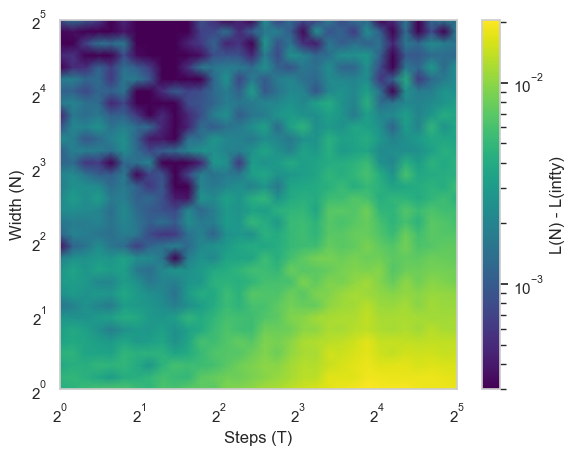

In [161]:
width_losses = np.zeros((32, 32))
steps = [int(i) for i in (np.geomspace(1, 16, 32) * 600)]
widths = [int(i) for i in (np.geomspace(1, 16, 32) * 256)]
for idx, width in enumerate(widths):
    t_losses = [np.mean(train_losses_fixlr_2[width][lr][step-100:step+100]) - np.mean(train_losses_infty[16384][lr][step-100:step+100]) for step in steps]
    width_losses[idx] = t_losses
width_losses[width_losses <= 3e-4] = 3e-4

x_vals = np.geomspace(1, 32, 32)
y_vals = np.geomspace(1, 32, 32)
X, Y = np.meshgrid(x_vals, y_vals)

pcm = plt.pcolormesh(X, Y, width_losses, shading='gouraud', cmap='viridis', norm=LogNorm())
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.colorbar(pcm, label='L(N) - L(infty)')
plt.xlabel('Steps (T)')
plt.ylabel('Width (N)')

In [ ]:
d_in=30
widths = [256, 512, 1024, 2048, 4096, 16384]
B = 512
T = 8100
lrs = np.logspace(-1.5, 0.5, 10)
teacher_weights = make_teacher(d_in, device, seed=42, teacher_width = 10000)
train_losses_mup = train_mup(d_in, widths, B, T, lrs, sample_batch_teacher, device)
display_results(widths, lrs, train_losses_mup)

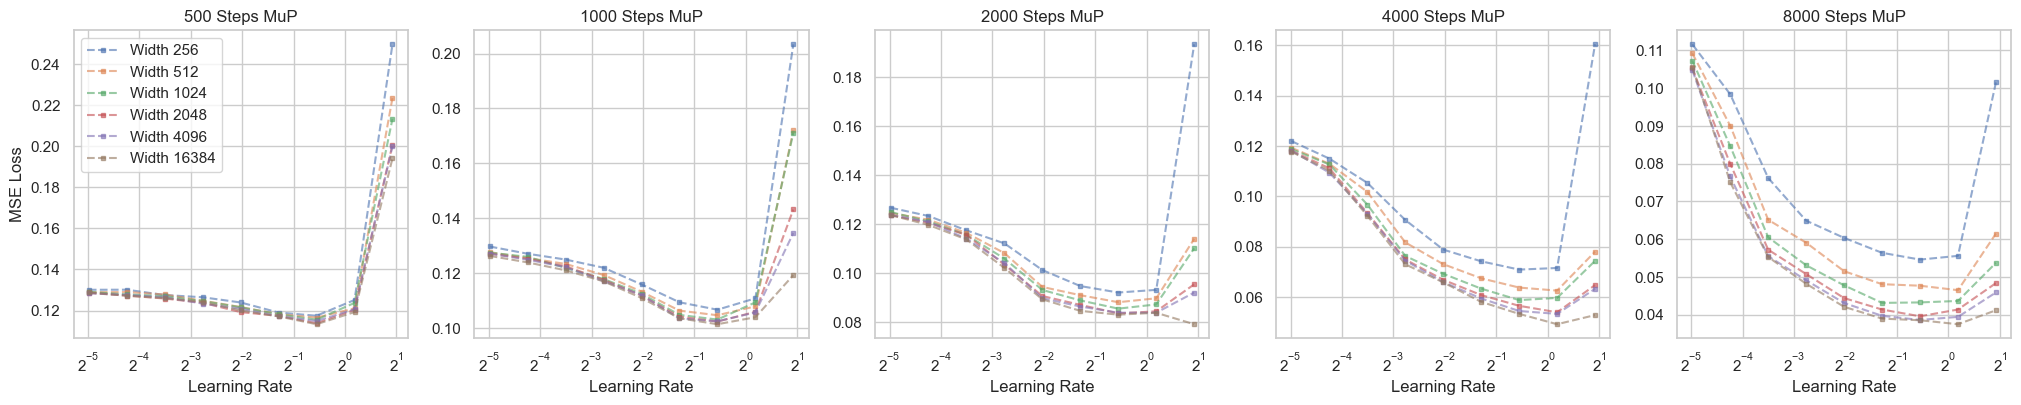

In [224]:
#MuP
lrs = np.logspace(-1.5, 0.5, 10)
steps = [500, 1000, 2000, 4000, 8000]
widths = [256, 512, 1024, 2048, 4096, 16384, ]
plot_stuff(steps, lrs, train_losses_mup, widths, note='MuP')

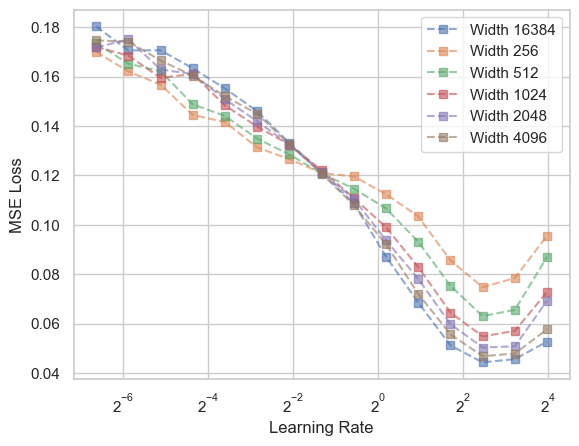

In [153]:
d_in=32
widths = [16384, 256, 512, 1024, 2048, 4096, ]
B = 512
T = 10100
lrs = np.logspace(-2.0, 1.2, 15)
teacher_weights = make_teacher(d_in, device, seed=42, teacher_width = 20000)
train_losses_ntk = train_ntk(d_in, widths, B, T, lrs, sample_batch_teacher, device)
display_results(widths, lrs, train_losses_ntk)

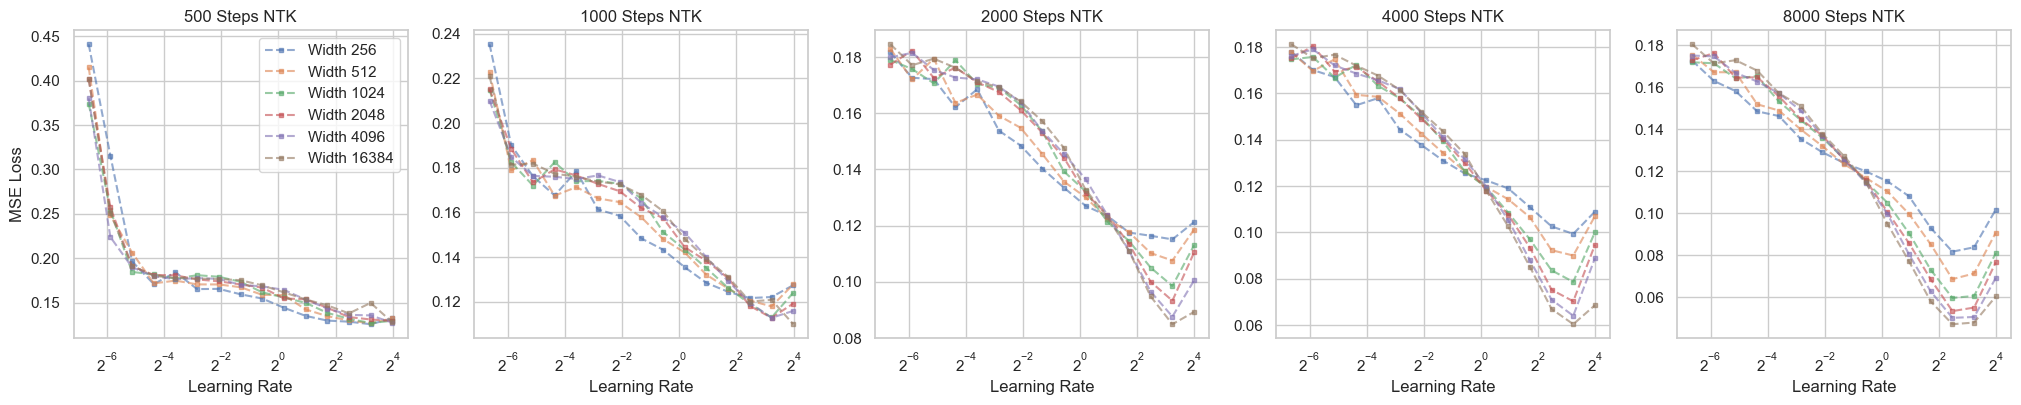

In [223]:
#NTK
steps = [500, 1000, 2000, 4000, 8000]
widths = [256, 512, 1024, 2048, 4096, 16384, ]
lrs = np.logspace(-2.0, 1.2, 15)
plot_stuff(steps, lrs, train_losses_ntk, widths)

Training width 512
Training width 1024
Training width 2048
Training width 4096


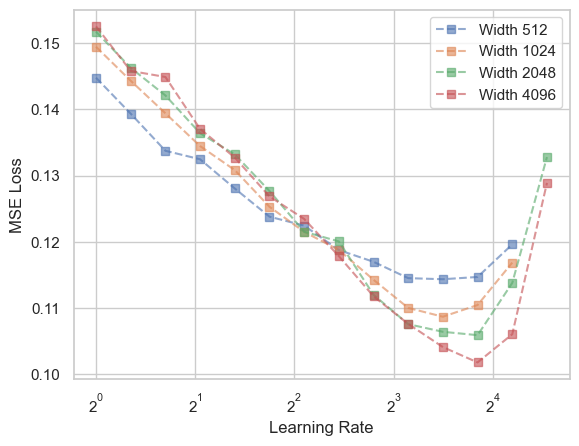

In [197]:
d_in=32
widths = [512, 1024, 2048, 4096, ]
B = 2048
T = 1000
lrs = np.logspace(0.0, 2.0, 20)
teacher_weights = make_teacher(d_in, device, seed=42, teacher_width = 20000)
train_losses_ntk_bigbatch = train_ntk(d_in, widths, B, T, lrs, sample_batch_teacher, device, verbose=True)
display_results(widths, lrs, train_losses_ntk_bigbatch)

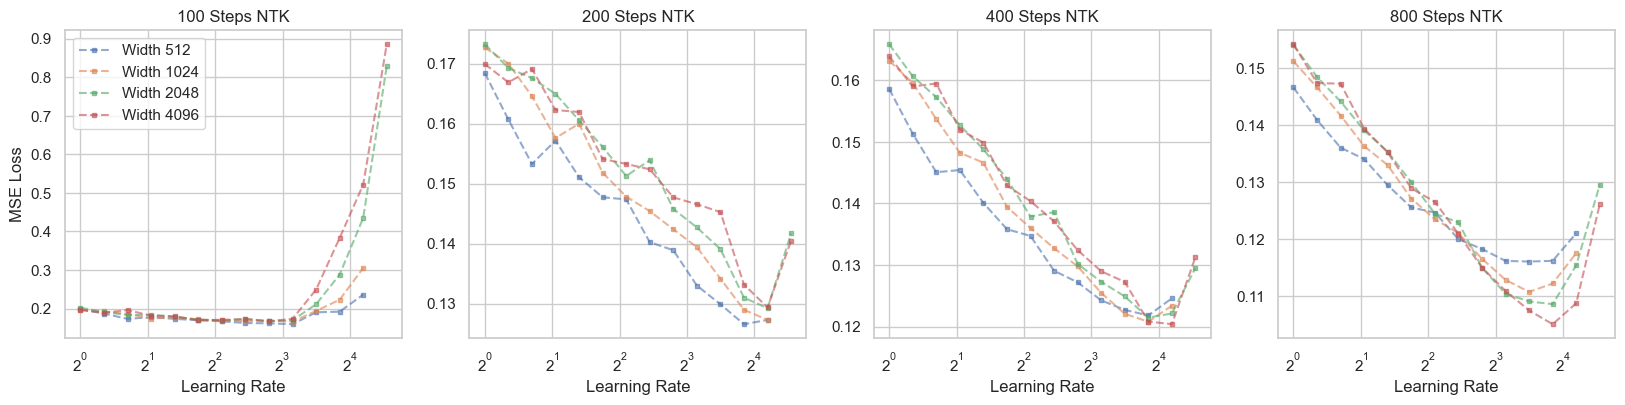

In [215]:
#NTK
steps = [100, 200, 400, 800]
widths = [512, 1024, 2048, 4096, ]
lrs = np.logspace(0.0, 2.0, 20)
plot_stuff(steps, lrs, train_losses_ntk_bigbatch, widths)

In [174]:
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1e9, "GB allocated")
print(torch.cuda.memory_reserved() / 1e9, "GB reserved")

0.01703936 GB allocated
0.02097152 GB reserved
